In [55]:
import tensorflow as tf
from PIL import Image
import os
import random
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Classify invasive hydrangea species
- Resources: http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/

### Setup the classes

In [5]:
classes = ['invasive','non_invasive']
n_classes = len(classes)

#### Setup the data


In [11]:
batch_size = 16
img_size =  128

In [30]:
test_image = Image.open("../data/test/1.jpg")

In [31]:
np.array(test_image)

(866, 1154, 3)

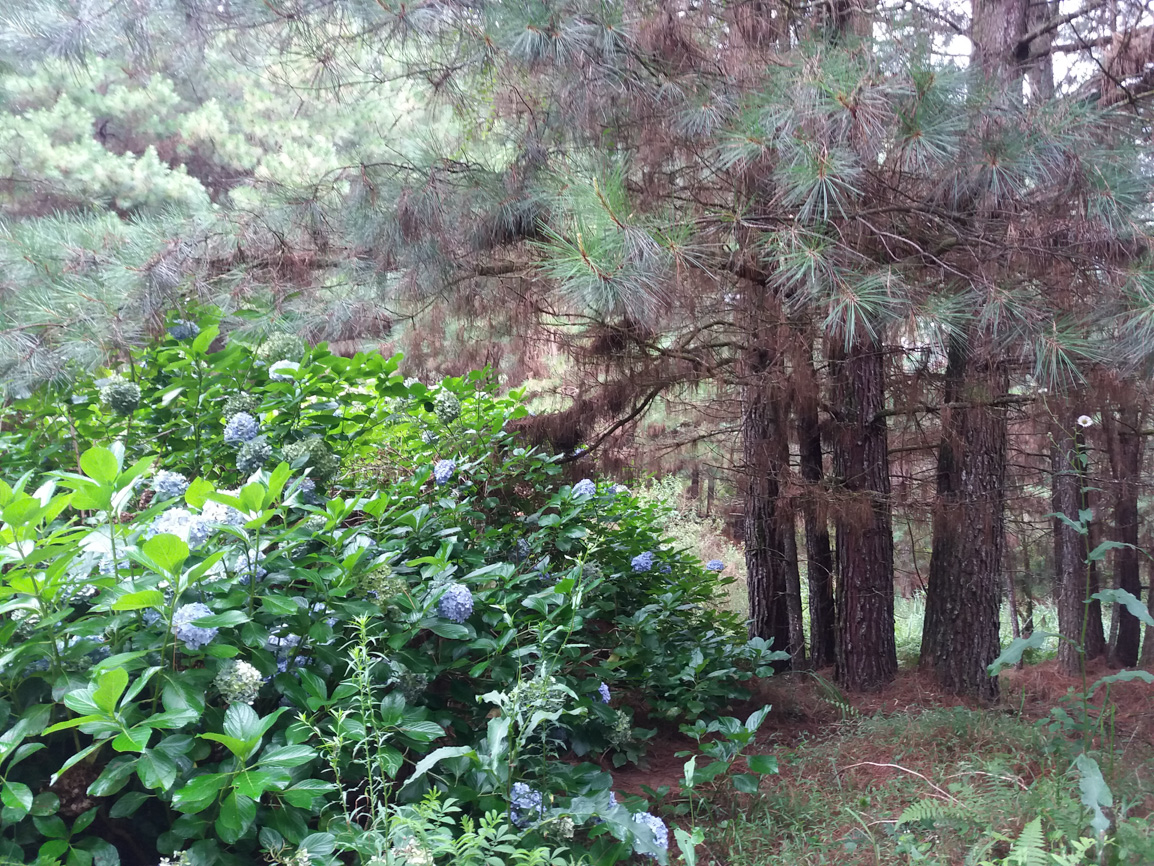

In [35]:
test_image

- resize each image

In [80]:
arr = np.array(test_image.resize((128,128)))

In [83]:
arr.flatten().shape

(49152,)

## Read in the data
- change size to 128 x 128 x 3
- flatten image to one-d (128 $* 128 *$ 3)

In [195]:
def train_generator(batch_size, img_size=128):
    """A generator for the training data.
    Resizes the images to img_size by img_size
    Flattens the image into a one-dimensional image
    returns a batch with labels transformed in [0,1]  for the negative case and [1,0]
    Returns images, labels"""
    all_images = os.listdir("../data/train")
    # shuffle the images
    random.shuffle(all_images)
    
    # get the labels
    labels = pd.read_csv("../data/train_labels-1.csv")
    labels_dict = {label[1]['name']:label[1]['invasive'] for label in labels.iterrows()}
    
    
    # all images resized
    image_batch = []
    labels = []
    # batches returned
    batches_returned = 0
    for idx,train_image in enumerate(all_images):        
        if batches_returned >0:
            if ((idx) % (batches_returned*batch_size) ==0) & (idx !=0):
                # reset the lists to yield the correct batch size
                image_batch = []
                labels = []

        # find the label for our image
        image_number = int(train_image.split('.')[0])
        # either 1 or 0
        coresponding_label = labels_dict[image_number]
        
        if coresponding_label == 1:
            labels.append([1,0])
        elif coresponding_label == 0:
            labels.append([0,1])
            
        # get the image
        t_image = Image.open("../data/train/"+train_image)
        # resize
        t_image = np.array(t_image.resize((img_size,img_size)))
        # get our batch ready
        image_batch.append(t_image.flatten())
        if ((idx+1) % batch_size ==0) & idx !=0:
            batches_returned +=1
            yield np.array(image_batch), labels

In [196]:
gen = train_generator(2)

In [197]:
img, lab = next(gen)

In [57]:
labels = pd.read_csv("../data/train_labels-1.csv")

In [65]:
for i in labels.iterrows():
    print(i[1])
    break

name        1
invasive    0
Name: 0, dtype: int64


In [67]:
labels = {label[1]['name']:label[1]['invasive'] for label in labels.iterrows()}

- Define function for weights and variables

In [2]:

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [4]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

- Define a new convolution layer

In [7]:

 
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
 
    shape = [filter_size, filter_size,  num_input_channels, num_filters]
 
    weights = new_weights(shape=shape)
 
    biases = new_biases(length=num_filters)
 
    layer = tf.nn.conv2d(input=input,
    	             filter=weights,
    	             strides=[1, 1, 1, 1],
    	             padding='SAME')
 
    layer += biases
 
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

- Flaten the output of the CNN layer for classification

In [8]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
 
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

- Define a fully connected layer

In [9]:
def new_fc_layer(input,      
             num_inputs,     
             num_outputs,    
             use_relu=True): 
 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
 
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
 
    return layer

In [ ]:
tf.reshape()